In [87]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [88]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [89]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 8, 17, 14, 45, 835362)

In [90]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-08 17:14:45,869 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 17:14:45,908 INFO: Initializing external client
2025-01-08 17:14:45,910 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 17:14:47,272 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [91]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [92]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [93]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [94]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [95]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-16 22:00:00+00:00,2.95,0.064256,0.0,0.0,7.928178,29183.220703,0.0,dublin,1,3,22
1,2025-01-14 08:00:00+00:00,8.40,5.555632,0.0,0.0,14.264361,28859.789062,0.0,dublin,1,1,8
2,2025-01-15 15:00:00+00:00,4.60,2.492247,0.0,0.0,2.902413,29019.097656,0.0,dublin,1,2,15
3,2025-01-12 03:00:00+00:00,3.15,0.541611,0.0,0.0,6.638072,28556.771484,0.0,dublin,1,6,3
4,2025-01-12 01:00:00+00:00,3.70,1.288777,0.0,0.0,5.804825,28556.771484,0.0,dublin,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
216,2025-01-12 02:00:00+00:00,3.45,0.962345,0.0,0.0,6.193674,28556.771484,0.0,dublin,1,6,2
217,2025-01-12 21:00:00+00:00,10.90,7.563490,0.0,0.0,20.140705,28556.771484,0.0,dublin,1,6,21
218,2025-01-09 19:00:00+00:00,-2.15,-5.771578,0.0,0.0,7.636753,28145.916016,0.0,dublin,1,3,19
219,2025-01-16 13:00:00+00:00,6.80,4.694598,0.0,0.0,6.725354,29183.220703,0.0,dublin,1,3,13


## Creating predictions

In [96]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-01-16 22:00:00+00:00,2.95,0.064256,0.0,0.0,7.928178,29183.220703,0.0,dublin,1,3,22,39
1,2025-01-14 08:00:00+00:00,8.40,5.555632,0.0,0.0,14.264361,28859.789062,0.0,dublin,1,1,8,22
2,2025-01-15 15:00:00+00:00,4.60,2.492247,0.0,0.0,2.902413,29019.097656,0.0,dublin,1,2,15,5
3,2025-01-12 03:00:00+00:00,3.15,0.541611,0.0,0.0,6.638072,28556.771484,0.0,dublin,1,6,3,38
4,2025-01-12 01:00:00+00:00,3.70,1.288777,0.0,0.0,5.804825,28556.771484,0.0,dublin,1,6,1,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2025-01-12 02:00:00+00:00,3.45,0.962345,0.0,0.0,6.193674,28556.771484,0.0,dublin,1,6,2,37
217,2025-01-12 21:00:00+00:00,10.90,7.563490,0.0,0.0,20.140705,28556.771484,0.0,dublin,1,6,21,36
218,2025-01-09 19:00:00+00:00,-2.15,-5.771578,0.0,0.0,7.636753,28145.916016,0.0,dublin,1,3,19,41
219,2025-01-16 13:00:00+00:00,6.80,4.694598,0.0,0.0,6.725354,29183.220703,0.0,dublin,1,3,13,7


In [97]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
135,2025-01-08 19:00:00+00:00,-0.45,-4.407723,0.0,0.0,10.966713,28021.865234,0.0,dublin,1,2,19,36,1
20,2025-01-08 20:00:00+00:00,-1.00,-5.029679,0.0,0.0,10.948973,28021.865234,0.0,dublin,1,2,20,40,2
153,2025-01-08 21:00:00+00:00,-1.40,-5.497227,0.0,0.0,11.183201,28021.865234,0.0,dublin,1,2,21,41,3
24,2025-01-08 22:00:00+00:00,-1.70,-5.835074,0.0,0.0,11.304229,28021.865234,0.0,dublin,1,2,22,41,4
62,2025-01-08 23:00:00+00:00,-1.90,-6.142219,0.0,0.0,11.988594,28021.865234,0.0,dublin,1,2,23,41,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,2025-01-17 19:00:00+00:00,5.05,1.534287,0.0,0.0,14.578890,29351.843750,0.0,dublin,1,4,19,34,217
166,2025-01-17 20:00:00+00:00,4.85,1.368568,0.0,0.0,14.277983,29351.843750,0.0,dublin,1,4,20,34,218
122,2025-01-17 21:00:00+00:00,4.60,1.185653,0.0,0.0,13.479583,29351.843750,0.0,dublin,1,4,21,34,219
63,2025-01-17 22:00:00+00:00,4.30,0.943740,0.0,0.0,12.682018,29351.843750,0.0,dublin,1,4,22,34,220


## Create forecast graph

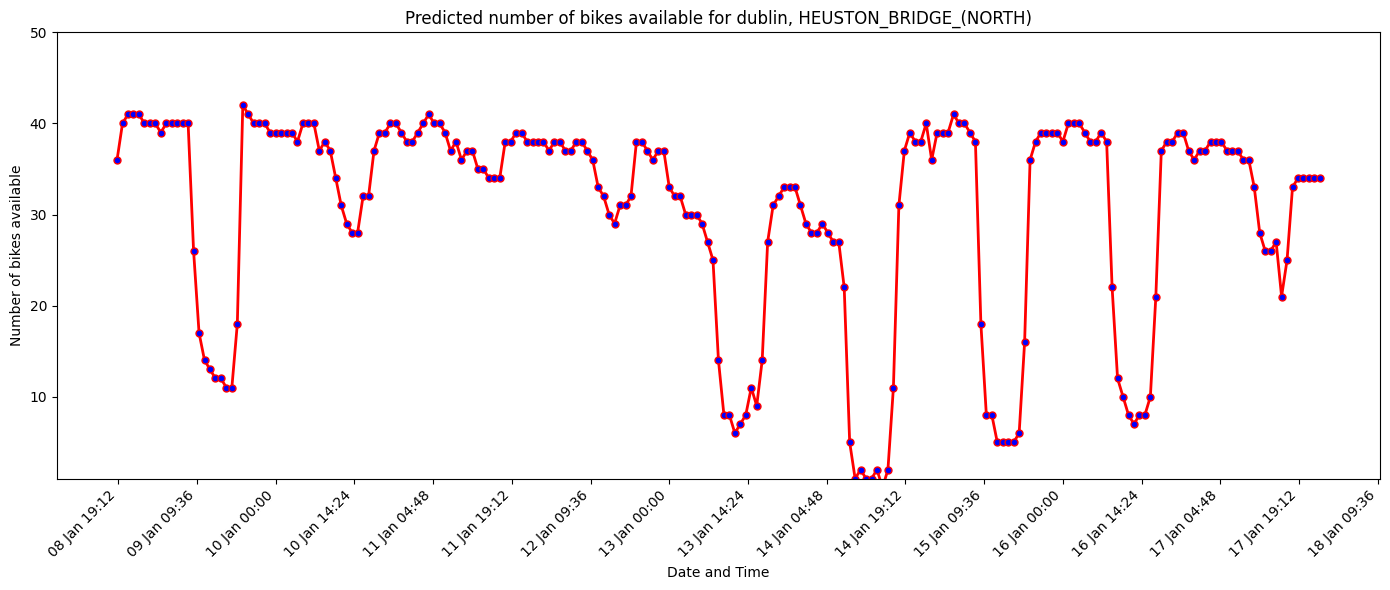

In [98]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [99]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [100]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1207494/fs/1195126/fg/1394797


Uploading Dataframe: 100.00% |██████████| Rows 221/221 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-08 17:15:13,308 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-08 17:15:16,482 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-08 17:17:20,277 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-08 17:17:20,433 INFO: Waiting for log aggregation to finish.
2025-01-08 17:17:29,108 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [101]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time <= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-08 20:00:00+00:00,-1.00,-5.029679,0.0,0.0,10.948973,28021.865234,0.0,dublin,1,2,20,40,2
1,2025-01-09 17:00:00+00:00,-0.30,-4.090576,0.0,0.0,10.105681,28145.916016,0.0,dublin,1,3,17,18,23
2,2025-01-09 01:00:00+00:00,-2.20,-6.534487,0.0,0.0,12.481153,28145.916016,0.0,dublin,1,3,1,40,7
3,2025-01-09 12:00:00+00:00,0.35,-4.131927,0.0,0.0,15.188415,28145.916016,0.0,dublin,1,3,12,13,18
4,2025-01-09 05:00:00+00:00,-2.45,-7.008852,0.0,0.0,14.044615,28145.916016,0.0,dublin,1,3,5,40,11
5,2025-01-09 16:00:00+00:00,0.85,-3.106200,0.0,0.0,11.928989,28145.916016,0.0,dublin,1,3,16,11,22
6,2025-01-09 06:00:00+00:00,-2.45,-7.063302,0.0,0.0,14.417988,28145.916016,0.0,dublin,1,3,6,40,12
7,2025-01-09 11:00:00+00:00,-0.45,-4.982267,0.0,0.0,15.188415,28145.916016,0.0,dublin,1,3,11,14,17
8,2025-01-09 04:00:00+00:00,-2.40,-6.986290,0.0,0.0,14.154915,28145.916016,0.0,dublin,1,3,4,40,10
9,2025-01-08 19:00:00+00:00,-0.45,-4.407723,0.0,0.0,10.966713,28021.865234,0.0,dublin,1,2,19,36,1


In [102]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()
bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
9274,2023-11-30 17:00:00+00:00,HEUSTON_BRIDGE_(NORTH),25.0
9275,2023-12-31 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),14.0
9276,2023-12-07 19:00:00+00:00,HEUSTON_BRIDGE_(NORTH),37.0
9277,2024-11-30 00:00:00+00:00,HEUSTON_BRIDGE_(NORTH),39.0


In [103]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.6,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.9,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.5,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.3,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.0,dublin
...,...,...,...,...,...,...,...,...,...
12691,2025-01-12 02:00:00+00:00,3.4500,0.962345,0.0,0.0,6.193674,28556.771484,0.0,dublin
12692,2025-01-12 21:00:00+00:00,10.9000,7.563490,0.0,0.0,20.140705,28556.771484,0.0,dublin
12693,2025-01-09 19:00:00+00:00,-2.1500,-5.771578,0.0,0.0,7.636753,28145.916016,0.0,dublin
12694,2025-01-16 13:00:00+00:00,6.8000,4.694598,0.0,0.0,6.725354,29183.220703,0.0,dublin


In [104]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [105]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])
print(len(hindcast_df))
hindcast_df

0


,datetime,predicted_bikes_available,num_bikes_available


In [106]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 


Uploading Dataframe: 100.00% |██████████| Rows 240/240 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-08 17:17:51,568 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-08 17:17:54,747 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-08 17:20:04,898 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-08 17:20:05,054 INFO: Waiting for log aggregation to finish.
2025-01-08 17:20:53,779 INFO: Execution finished successfully.


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,num_bikes_available,predicted_bikes_available,hours_before_forecast_time
4428,2024-12-28 16:00:00+00:00,8.539500,5.723537,0.0,0.0,14.941085,27194.826172,0.0,dublin,12,5,16,34.0,32,1
5717,2024-12-28 17:00:00+00:00,8.789500,5.991804,0.0,0.0,15.070633,27194.826172,0.0,dublin,12,5,17,33.0,31,2
7205,2024-12-28 18:00:00+00:00,9.139501,6.359324,0.0,0.0,15.380260,27194.826172,0.0,dublin,12,5,18,34.0,32,3
5998,2024-12-28 19:00:00+00:00,9.239500,6.363287,0.0,0.0,16.299694,27194.826172,0.0,dublin,12,5,19,33.0,32,4
8433,2024-12-28 20:00:00+00:00,9.289500,6.719114,0.0,0.0,14.731437,27194.826172,0.0,dublin,12,5,20,34.0,32,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9250,2025-01-08 11:00:00+00:00,0.050000,-2.757509,0.0,0.0,3.706427,28021.865234,0.0,dublin,1,2,11,39.0,9,236
9248,2025-01-08 12:00:00+00:00,1.400000,-1.355652,0.0,0.0,4.582052,28021.865234,0.0,dublin,1,2,12,38.0,9,237
9241,2025-01-08 13:00:00+00:00,2.100000,-0.793506,0.0,0.0,6.120000,28021.865234,0.0,dublin,1,2,13,39.0,8,238
9252,2025-01-08 14:00:00+00:00,2.450000,-0.681665,0.0,0.0,7.968939,28021.865234,0.0,dublin,1,2,14,39.0,7,239


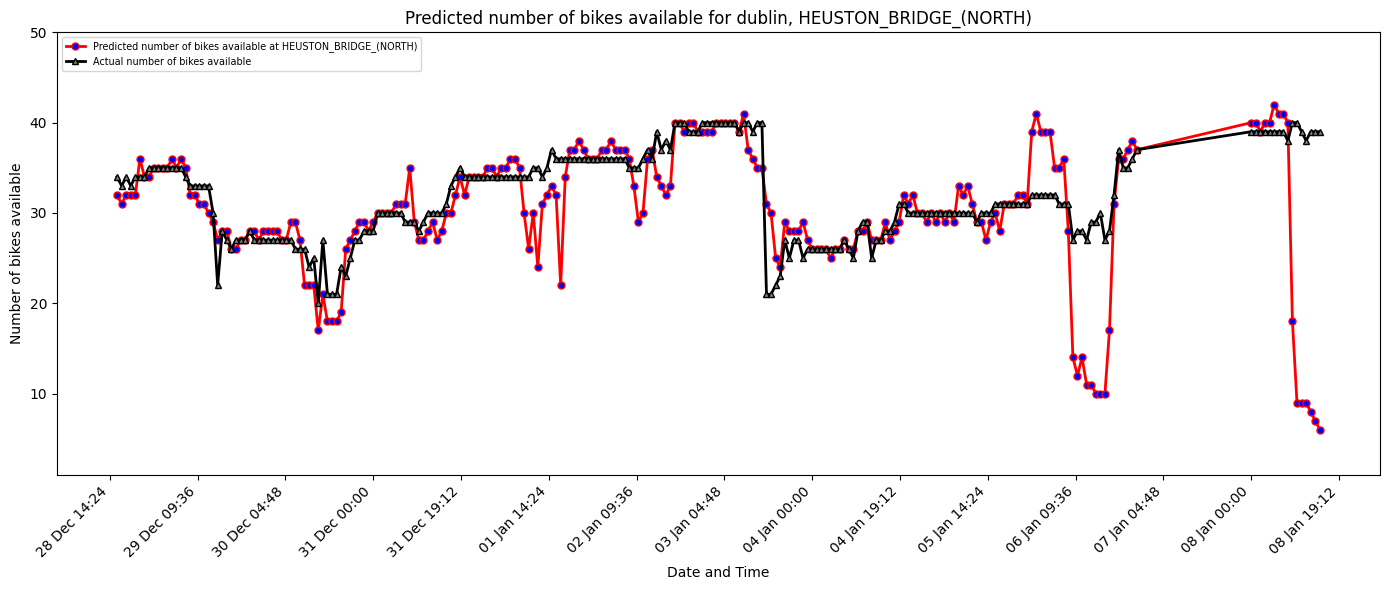

In [108]:
file_path = "docs/bike_availability_hindcast_1day.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df, file_path, hindcast=True)
plt.show()